# Lab 5 - Logistic Regression

In this lab we implement and use logistic regressione for binary claffication problems.

We start including some libraries and functions already seen in the previous labs (or slight variations of them). Have a look and verify you understand their purpose.

<b>READ all the text parts very carefully, as you will find instructions on how to proceed.</b>

In [1]:
# import libraries
%matplotlib notebook
%matplotlib inline
# Andres  Coronado  2761046
# Giacomo Garbarino 4545532
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.interpolate import griddata
import math

In [2]:
def mixGauss(means, sigmas, n):
    """
    means : 2D array (num_classes, d)
        Each row of the array gives the mean of the Gaussian in multiple dimensions for one class.
        For binary classification problems, the number of rows should be 2!
    sigmas : 1D array (num_classes)
        The standard deviation for the Gaussian distribution of each class (isotropic Gaussian!)
    
    Example:
    
    >>> means = [[3, 0], [0, 0]]
    >>> sigmas = [0.5, 1]
    >>> X, Y = mixGauss(means, sigmas, n=100)
    >>> fig, ax = plt.subplots()
    >>> ax.scatter(X[Y == 1,0], X[Y == 1,1], marker='o', color='r')
    >>> ax.scatter(X[Y == -1,0], X[Y == -1,1], marker='o', color='b')
    """
    means = np.array(means)
    sigmas = np.array(sigmas)

    d = means.shape[1]
    num_classes = sigmas.size
    data = np.full((n * num_classes, d), np.inf)
    labels = np.zeros(n * num_classes)

    for idx, sigma in enumerate(sigmas):
        data[idx * n:(idx + 1) * n] = np.random.multivariate_normal(
            mean=means[idx], cov=np.eye(d) * sigmas[idx] ** 2, size=n)
        labels[idx * n:(idx + 1) * n] = idx 
        
    if(num_classes == 2):
        labels[labels==0] = -1

    return data, labels

In [3]:
def flipLabels(Y, perc):
    if perc < 1 or perc > 100:
        print("p should be a percentage value between 0 and 100.")
        return -1

    if any(np.abs(Y) != 1):
        print("The values of Ytr should be +1 or -1.")
        return -1

    Y_noisy = np.copy(np.squeeze(Y))
    if Y_noisy.ndim > 1:
        print("Please supply a label array with only one dimension")
        return -1

    n = Y_noisy.size
    n_flips = int(np.floor(n * perc / 100))
    idx_to_flip = np.random.choice(n, size=n_flips, replace=False)
    Y_noisy[idx_to_flip] = -Y_noisy[idx_to_flip]

    return Y_noisy

In [4]:
def separatingFLR(Xtr, Ytr, Ypred):
    xi = np.linspace(Xtr[:, 0].min(), Xtr[:, 0].max(), 200)
    yi = np.linspace(Xtr[:, 1].min(), Xtr[:, 1].max(), 200)
    X, Y = np.meshgrid(xi,yi)
    
    zi = griddata(Xtr, Ypred, (X,Y), method='linear')
    
    plt.contour(xi, yi, zi, 15, linewidths=2, colors='k', levels=[0])
    # plot data points.
    plt.scatter(Xtr[:,0], Xtr[:,1], c=Ytr, marker='o', s=100, zorder=10, alpha=0.8)
    plt.xlim(Xtr[:,0].min(), Xtr[:,0].max())
    plt.ylim(Xtr[:,1].min(), Xtr[:,1].max())

## Linear logistic regression with gradient descent

We define two functions:
 - the `optimal_gd_learning_rate(Xtr, reg_par)` function calculates the optimal learning rate for GD on a given dataset. You will need to use the SVD of the covariance matrix.
 - the `train_logreg_gd(Xtr, Ytr, reg_par, maxiter)` function estimates the classifier weights on the training set.

<br>

The parameters of the `optimal_gd_learning_rate` function are:
- <b>Xtr</b> is the nxD matrix of training set inputs
- <b>reg_par</b> is the value of the lammbda

and it should output the learning rate $\gamma$ (a scalar).
You should use the `np.linalg.eigvalsh` function to calculate the eigenvalues of the covariance matrix.

<br>

The parameters of the `train_logreg_gd` function are:
- <b>Xtr</b> is the nxD matrix of training set inputs
- <b>Ytr</b> is the n vector of training set outputs
- <b>reg_par</b> is the value of the lammbda
- <b>maxiter</b> is the maximum number of iterations to run gradient descent

and it should output:
- <b>w</b> is the D vector of the estimated function parameters
- <b>losses</b> is the vector of the loss at each iteration


In [5]:
def optimal_gd_learning_rate(Xtr, reg_par):
    # Estimate the gamma parameter: the optimal learning rate for gradient descent
    n, D=np.shape(Xtr)
    eigvals = np.linalg.eigvalsh(np.dot(np.transpose(Xtr), Xtr))
    L = np.max(eigvals.astype(float))/ n + 2 * reg_par
    gamma = 1 / L
    return gamma

In [6]:
def train_logreg_gd(Xtr, Ytr, reg_par, maxiter=100):
    """
    Xtr : array of shape n, d
    Ytr : array of shape n, or of shape n, 1
    reg_par : regularization parameter (a scalar)
    maxiter : the maximum number of gradient-descent iterations
    """
    # Epsilon is a criterion for early stopping
    epsilon = 1e-6
    
    # size of the input in the training
    n, D = np.shape(Xtr)
    
    # initialization of the vector w
    w = np.zeros(D)
    
    # Set the learning rate optimally
    gamma = optimal_gd_learning_rate(Xtr, reg_par)
    
    # initialization of some supporting variables
    j=0
    loss_old = 0
    loss = float("inf")
    training_losses = np.zeros(maxiter + 1)
    #Ytr = Ytr.reshape(-1, 1)  # Convert from shape n, to shape n, 1
    while j < maxiter and abs(loss - loss_old) >= epsilon:
        loss_old = loss
        j = j + 1
        sum_w = np.zeros(D)
        for i in range(n):
            sum_w = np.add(sum_w ,Xtr[i] * (-Ytr[i])/(1 + np.exp(Ytr[i] * np.dot(Xtr[i].T, w))))
            
        w = w - gamma * ((1/n) * sum_w + 2*reg_par*w)
        
        sum_loss = 0
        for i in range(n):
            sum_loss +=np.log(1 + np.exp(-Ytr[i]*np.dot(w.T,Xtr[i])))
            
        loss = 1/n * sum_loss + reg_par * (np.linalg.norm(w,2)**2)
        training_losses[j] = abs(loss-loss_old)
    return w, training_losses[:j]
    

### Evaluation the function on the test set

A function to perform predictions on a set of samples given the learned logistic regression weights

##### Ypred, Ppred = predict_logreg(weights, Xte)
where
- <b>weights</b> is the D vector of the estimated function parameters
- <b>X</b> is the matrix of input points of the training or test set.
- <b>Ypred</b> is the vector of predictions
- <b>Ppred</b> is the predicted probability of a point belonging to class +1. It will be 0 if the model is very confident the point belongs to class -1, it will be 1 if the model is very confident that the point belongs to class +1.

In [7]:
def predict_logreg(weights, X):
    """
    weights : array of shape d, 1
    X : array of shape n, d
    """
    ypred = np.dot(X, weights)
    # Try and understand what it does, deriving the formula
    ppred = 1 / (1 + np.exp(-ypred))
    # The outputs are reshaped to be 1D vectors.
    return ypred.reshape(-1), ppred.reshape(-1)

In [8]:
def calcError(Ypred, Y):
    class_err = np.mean(np.sign(Ypred) != Y)
    return class_err

## Initial Analysis

Perform the following tasks for the initial analysis:

1. Create two binary classification datasets (training and test sets) -- Use the same parameters. Visualize them in a scatter plot.

2. Pick a reasonable value for lambda (e.g. reg_par = 0.1, 0.01, 0.001, ...) and train a logistic-regression model using the functions you have defined.

3. Plot the loss at each iteration which is returned by the training function. The loss should decrease at each iteration, **if the loss does not decrease there is an error in the implementation!**

4. Use the `separatingFLR` function to plot the separating curve obtained with the model

5. Evaluate the error training and test sets.

**Important #1**: The parameters used to generate the data are quite important. Try to make sure that the two classes are distinct (i.e. the means of the Gaussians should be different), but also not too far. Ideally a few points should overlap between the classes.
Make sure to generate at least 100 points for both train and test sets.

**Important #2**: since we are implementing a linear model, we must add a bias term -- otherwise the weights will draw a line which always goes through 0. An alternative to adding a bias term to the model is to add a feature comprising all ones to the data-column. We can use the following code for this:
```
Xtr_wbias = np.hstack((Xtr, np.ones((Xtr.shape[0], 1))))
Xts_wbias = np.hstack((Xts, np.ones((Xts.shape[0], 1))))
```
what whill be the resulting shape of the weight vector `w`?

The shape of w is:  (3,)


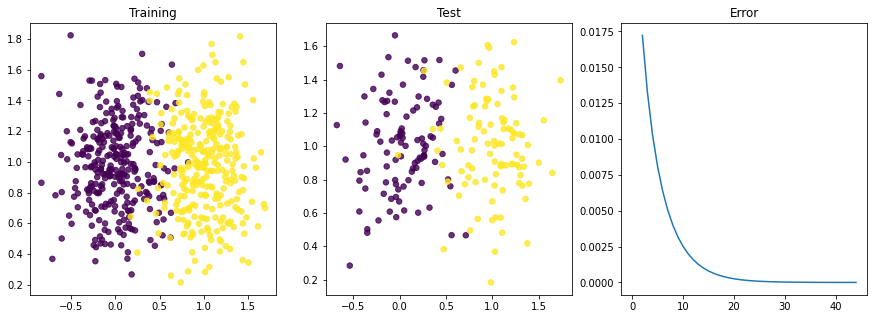

In [9]:
# Help for data-generation
means = [[0,1],[1,1]]
sigmas = [0.3, 0.3]

Xtr, Ytr = mixGauss(means, sigmas, 300)
Xts, Yts = mixGauss(means, sigmas, 100)

Xtr_wbias = np.hstack((Xtr, np.ones((Xtr.shape[0], 1))))
Xts_wbias = np.hstack((Xts, np.ones((Xts.shape[0], 1))))

reg_par = 10e-2

bestw, errs = train_logreg_gd(Xtr_wbias, Ytr, reg_par, 100)
print("The shape of w is: ", bestw.shape)

fig = plt.figure(figsize=(15,5))
ax0 = fig.add_subplot(1,3,1)
ax1 = fig.add_subplot(1,3,2)
ax2 = fig.add_subplot(1,3,3)
ax0.set_title("Training")
ax0.scatter(Xtr_wbias[:,0], Xtr_wbias[:,1], s=30, c=Ytr, alpha=0.80)
ax1.set_title("Test")
ax1.scatter(Xts_wbias[:,0], Xts_wbias[:,1], s=30, c=Yts, alpha=0.80)
ax2.set_title("Error")
ax2.plot(range(len(errs)), errs)

Training error: 7.83%, Test error: 7.50%


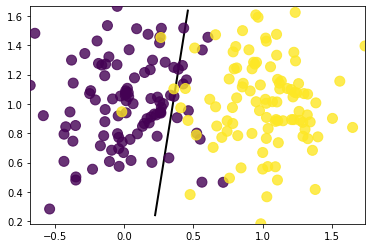

In [10]:
tr_pred, _ = predict_logreg(bestw, Xtr_wbias)
tr_err = calcError(tr_pred, Ytr)
ts_pred, _ = predict_logreg(bestw, Xts_wbias)
ts_err = calcError(ts_pred, Yts)
separatingFLR(Xts, Yts, ts_pred)
print("Training error: %.2f%%, Test error: %.2f%%" % (tr_err * 100, ts_err * 100))

## Interpreting the confidence of logistic regression predictions

Logistic regression does not only output *pointwise predictions* (the class to which a point belongs), but it also gives the **probability** that a test point belongs to a certain class.

This probability can be very useful to interpret the outputs of your model: in certain cases it might be better to **not predict anything** if the confidence of the model is low (i.e. if the model predicts a probability of 0.5 in a binary setting, the model is not sure which class a point belongs to).

In this part of the lab, we will
 1. Implement a function which allows to visualize the confidence of predictions (`plot_logreg_confidence`)
 2. Train a logistic regression model, and use the visualization function to see where the low confidence region of prediction lies.
 3. Calculate the error on **just the high-confidence** predictions, and see how the it changes.

In [11]:
def plot_logreg_confidence(X, Y, pred_confidence, threshold):
    """
    X : a (n, d) dataset
    Y : a (n, ) array of targets
    pred_confidence : A (n, ) array of probabilities predicted from X
    threshold : a float between 0 and 0.5 determining the probability threshold we use to 
                consider neutral predictions. For example if threshold=0.1 then all probabilities
                between 0.4 and 0.6 will be considered neutral (that is, neither belonging to class +1
                or to class -1).
    """
    xi = np.linspace(X[:, 0].min(), X[:, 0].max(), 200)
    yi = np.linspace(X[:, 1].min(), X[:, 1].max(), 200)
    X_grid, Y_grid = np.meshgrid(xi,yi)
    
    zi = griddata(X, pred_confidence, (X_grid, Y_grid), method='linear')
    
    plt.contour(xi, yi, zi, 15, linewidths=2, levels=[0.5 - threshold, 0.5 + threshold])
    
    # Plot data points
    plt.scatter(X[:,0], X[:,1], c=Y, 
               marker='o', s=100, zorder=10, alpha=0.8)
    plt.xlim(X[:,0].min(), X[:,0].max())
    plt.ylim(X[:,1].min(), X[:,1].max())

In [12]:
# Generate some data
Xtr, Ytr = mixGauss([[0,1],[1,1]], [0.4,0.4], 100)
Xts, Yts = mixGauss([[0,1],[1,1]], [0.4,0.4], 100)

Xtr_wbias = np.hstack((Xtr, np.ones((Xtr.shape[0], 1))))
Xts_wbias = np.hstack((Xts, np.ones((Xts.shape[0], 1))))


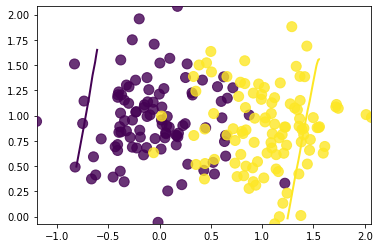

In [13]:
reg_par = 10e-2
bestw, errs = train_logreg_gd(Xtr_wbias, Ytr, reg_par, 100)
ts_pred, ts_conf = predict_logreg(bestw, Xts_wbias)
plot_logreg_confidence(Xts, Yts, ts_conf, 0.2)

In [14]:
def calc_error_with_confidence(prob_pred, Y, threshold):
    """
    Calculate the classification error on only the predictions with a high confidence!
    """
    class_m1 = prob_pred <= 0.5 - threshold
    class_p1 = prob_pred > 0.5 + threshold
    
    err_class_m1 = Y[class_m1] != -1
    err_class_p1 = Y[class_p1] != 1
    return (np.sum(err_class_m1) + np.sum(err_class_p1)) / (len(err_class_m1) + len(err_class_p1))

Test error: 0.00%


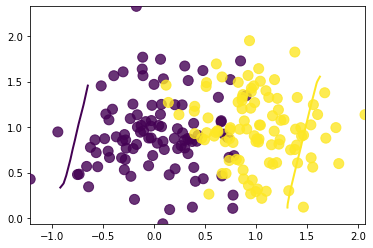

In [15]:
# Generate some data
Xtr, Ytr = mixGauss([[0,1],[1,1]], [0.4,0.4], 100)
Xts, Yts = mixGauss([[0,1],[1,1]], [0.4,0.4], 100)

Xtr_wbias = np.hstack((Xtr, np.ones((Xtr.shape[0], 1))))
Xts_wbias = np.hstack((Xts, np.ones((Xts.shape[0], 1))))

reg_par = 10e-2
bestw, errs = train_logreg_gd(Xtr_wbias, Ytr, reg_par, 100)
ts_pred, ts_conf = predict_logreg(bestw, Xts_wbias)
ts_err=calc_error_with_confidence(ts_conf, Yts, 0.2)
print("Test error: %.2f%%" % (ts_err*100))
plot_logreg_confidence(Xts, Yts, ts_conf, 0.2)

Using *threshold=0.2*, we only focus on very high-confidence points (very few points) and that's why the test error is *0.00%*.

## Logistic Regression with Stochastic Gradient Descent

SGD is quite similar to GD, but instead of updating the weights with the gradient of all the training samples at once, at each step it updates the weights with the **gradient of a single sample** picked at random from the training set.

Since at each iteration it uses a single sample it will be much faster, but it will need more iterations.

In this last part you will:
 1. Implement a SGD solver for logistic regression
 2. Use it to learn a logistic-regression model
 3. Compare the results to learning with GD.

In [16]:
def train_logreg_sgd(Xtr, Ytr, reg_par, maxiter=100):
    """
    Xtr : array of shape n, d
    Ytr : array of shape n, or of shape n, 1
    reg_par : regularization parameter (a scalar)
    maxiter : the maximum number of gradient-descent iterations
    """
    epsilon = 1e-6
    # size of the input in the training
    n, D = np.shape(Xtr)
    # initialization of the vector w
    w = np.zeros(D)
    loss = float("inf")
    # initialization of some supporting variables
    training_losses = np.zeros(maxiter+1)
    #Ytr = Ytr.reshape(-1, 1)  # Convert from shape n, to shape n, 1
    for j in range(maxiter):
        # The learning rate here is different from GD. You can take
        # a) 1 / sqrt(n)
        # b) 1 / sqrt(j) : the learning rate decreases at each iteration.
        # Which one do you expect leads to faster convergence?
        gamma = 1 / math.sqrt(j+1)
        i = np.random.randint(0, n)
        aux_w = np.zeros(D)
        aux_w = np.add(aux_w, Xtr[i] * (-Ytr[i])/(1 + np.exp(Ytr[i] * np.dot(Xtr[i].T, w))))
        w = w - gamma * (aux_w + 2*reg_par*w)
        aux_loss = 0
        for i in range(n):
            aux_loss += np.log(1 + np.exp(-Ytr[i]*np.dot(w.T,Xtr[i])))
            
        loss = 1/n * aux_loss + reg_par * (np.linalg.norm(w,2)**2)
        training_losses[j] = loss
            
        if j > 0 and abs(training_losses[j] - training_losses[j-1]) < epsilon:
            break
        
    return w, training_losses[:j]

In [29]:
Xtr, Ytr = mixGauss([[0,1],[1,1]], [0.4,0.4], 100)
Xts, Yts = mixGauss([[0,1],[1,1]], [0.4,0.4], 100)

Xtr_wbias = np.hstack((Xtr, np.ones((Xtr.shape[0], 1))))
Xts_wbias = np.hstack((Xts, np.ones((Xts.shape[0], 1))))

Test error with GD: 0.00%
Test error with SGD: 0.00%


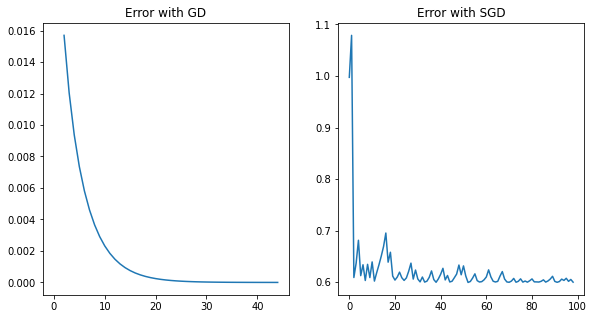

In [30]:
reg_par = 10e-2

bestw_gd, errs_gd = train_logreg_gd(Xtr_wbias, Ytr, reg_par, 100)
ts_pred_gd, ts_conf_gd = predict_logreg(bestw_gd, Xts_wbias)
ts_err_gd=calc_error_with_confidence(ts_conf_gd, Yts, 0.2)
print("Test error with GD: %.2f%%" % (ts_err_gd*100))

bestw_sgd, errs_sgd = train_logreg_sgd(Xtr_wbias, Ytr, reg_par, 100)
ts_pred_sgd, ts_conf_sgd = predict_logreg(bestw_sgd, Xts_wbias)
ts_err_sgd=calc_error_with_confidence(ts_conf_sgd, Yts, 0.2)
print("Test error with SGD: %.2f%%" % (ts_err_sgd*100))


fig = plt.figure(figsize=(15,5))
ax0 = fig.add_subplot(1,3,1)
ax1 = fig.add_subplot(1,3,2)
ax0.set_title("Error with GD")
ax0.plot(range(len(errs_gd)), errs_gd)
ax1.set_title("Error with SGD")
ax1.plot(range(len(errs_sgd)), errs_sgd)


## Conclusions

We can observe that the plot error using GD is more stable than SGD (SGD is more 'noisy'). Changing the learning rate formula of SGD, we can observe that SGD with *gamma=1/sqrt(j+1)* leads to a faster convergence than using *gamma=1/sqrt(n)*. We can observe again that with a *threshold=0.2*, the test error with both methods is *0.00%* because we only focus on very high-confidence points.